Looking at the problems first. We choose make blobs and make moons to look at how MPA performs against SVM head to head on some synthetic datasets with known, basic properties. 
Make moon random state = 3, noise = 0.18
train test split random state = 12

In [1]:
import numpy as np
from scipy.interpolate import make_smoothing_spline
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.datasets import make_moons

In [ ]:
X, y = make_blobs(n_features=2, n_samples=300, random_state = 14, centers = 2, cluster_std = 5)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Blobs Dataset")
plt.show()

In [3]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class MPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.005, epochs=50, random_state=7, verbose=False,
                 lambda_scaling='log', patience=5, decay_factor=0.5, min_learning_rate=1e-6):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_scaling = lambda_scaling
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.error_history_ = []
        self.learning_rate_history_ = []
        if lambda_scaling not in ['log', 'sqrt', 'none']:
            raise ValueError("lambda_scaling must be one of 'log', 'sqrt', or 'none'")
        np.random.seed(random_state)

    def _calculate_medians(self, X, y):
        mask_1 = y == 1
        self.m1 = X[mask_1].mean(axis=0)
        self.m0 = X[~mask_1].mean(axis=0)
        self.normal_vector = self.m0 - self.m1
        self.reference_point = (self.m0 + self.m1) / 2

    def _update_pseudo_labels(self, X, y):
        """Dynamically update pseudo-labels based on current hyperplane"""
        m1_displacement = self._calculate_displacement(self.m1.reshape(1, -1))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _generate_hyperplane_points(self, n_points):
        # Random points in the feature space (scaled to data range)
        return np.random.uniform(-100, 100, size=(n_points, self.n_features))

    def _calculate_displacement(self, points):
        normal_vector = self.hyperplane_coefficients[:-1]
        constant_term = self.hyperplane_coefficients[-1]
        numerator = np.dot(points, normal_vector) + constant_term
        denominator = np.sqrt(np.sum(normal_vector**2))
        return numerator / denominator

    def _find_hyperplane(self, points):
        A = np.hstack((points, np.ones((len(points), 1))))
        _, _, Vh = np.linalg.svd(A)
        return Vh[-1, :]

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        if not set(self.classes_).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        X = np.asarray(X)
        y = np.asarray(y)
        self.n_features = X.shape[1]

        # Store data range for random initialization
        self.X_range = (X.min(axis=0), X.max(axis=0))

        # Calculate medians for updates
        self._calculate_medians(X, y)
        self.hyperplane_points = self._generate_hyperplane_points(self.n_features)

        best_error = float('inf')
        patience_counter = 0
        current_learning_rate = self.initial_learning_rate

        self.error_history_ = []
        self.learning_rate_history_ = []

        # Precompute indices for each class
        indices_class_0 = np.where(y == 0)[0]
        indices_class_1 = np.where(y == 1)[0]

        for epoch in range(self.epochs):
            self.hyperplane_coefficients = self._find_hyperplane(self.hyperplane_points)
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)  # Precompute once per epoch
            errors = (displacements * pseudo_labels <= 0)
            error_count = np.sum(errors)

            self.error_history_.append(error_count)
            self.learning_rate_history_.append(current_learning_rate)

            if self.verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_learning_rate:.6f}")

            if error_count < best_error:
                best_error = error_count
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_learning_rate = max(current_learning_rate * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_learning_rate == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min LR reached at epoch {epoch}")
                        break

            if errors.any():
                error_indices = np.where(errors)[0]
                for idx in error_indices:
                    d = X[idx]
                    differences = self.hyperplane_points - d
                    distances = np.linalg.norm(differences, axis=1)
                    nearest_idx = np.argmin(distances)

                    distance = distances[nearest_idx]
                    lmbda = (np.log1p(distance) if self.lambda_scaling == 'log' else
                             np.sqrt(distance) if self.lambda_scaling == 'sqrt' else distance)

                    # Use precomputed indices and pseudo-labels
                    if y[idx] == 1:
                        opposite_indices = indices_class_0
                        opposite_pseudo_labels = self.class_0_pseudo
                    else:
                        opposite_indices = indices_class_1
                        opposite_pseudo_labels = self.class_1_pseudo

                    if len(opposite_indices) > 25:
                        sampled_indices = np.random.choice(opposite_indices, 25, replace=False)
                    else:
                        sampled_indices = opposite_indices

                    # Use precomputed displacements
                    sampled_displacements = displacements[sampled_indices]
                    correct_mask = sampled_displacements * opposite_pseudo_labels > 0
                    correct_targets_indices = sampled_indices[correct_mask]

                    if len(correct_targets_indices) > 10:
                        final_indices = np.random.choice(correct_targets_indices, 10, replace=False)
                    else:
                        final_indices = correct_targets_indices

                    if len(final_indices) > 0:
                        correct_targets = X[final_indices]
                        displacement_vectors = correct_targets - self.hyperplane_points[nearest_idx]
                        norms = np.linalg.norm(displacement_vectors, axis=1)
                        unit_vectors = displacement_vectors / norms[:, np.newaxis]
                        avg_unit_vector = np.mean(unit_vectors, axis=0)
                        avg_unit_vector /= np.linalg.norm(avg_unit_vector)
                        step = avg_unit_vector * lmbda * current_learning_rate
                        self.hyperplane_points[nearest_idx] += step
                    else:
                        target = self.m0 if y[idx] == 1 else self.m1
                        displacement_vector = target - self.hyperplane_points[nearest_idx]
                        unit_vector = displacement_vector / np.linalg.norm(displacement_vector)
                        self.hyperplane_points[nearest_idx] += unit_vector * lmbda * current_learning_rate

        return self

    def predict(self, X):
        X = np.asarray(X)
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def plot_convergence(self, figsize=(12, 5)):
        """
        Plot convergence history like it's your model's Instagram story 📱
        """
        try:
            import matplotlib.pyplot as plt

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

            ax1.plot(self.error_history_, 'b-', label='Errors')
            ax1.set_title('Error Convergence')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Number of Errors')
            ax1.grid(True)

            ax2.plot(self.learning_rate_history_, 'r-', label='Learning Rate')
            ax2.set_title('Learning Rate Decay')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_yscale('log')
            ax2.grid(True)

            plt.tight_layout()
            return fig

        except ImportError:
            print("Matplotlib is like that friend who didn't show up to the party. Install it with 'pip install matplotlib'")
            return None

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12)

In [ ]:
# Define the parameter grid for the MPA classifier
param_grid = {
    'learning_rate': [1.e-04, 1.e-03, 1.e-02, 1.e-01],
    'epochs': [10, 100, 150, 250, 400],
    'lambda_scaling': ['log', 'sqrt'],
    'patience': [5, 10],
    'decay_factor': [0.5, 0.75, 0.9, 1, 2],
    'min_learning_rate': [1e-6, 1e-5],
}


scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

# Create an instance of MPA
mpa = MPA(random_state=23)  # Assuming MPA has a random_state parameter

# Instantiate the GridSearchCV object:
# - 'mpa' is the estimator
# - 'param_grid' defines the parameters to try
# - 'cv=5' means 5-fold cross-validation
# - 'scoring='accuracy'' uses accuracy to compare model performance
# - 'n_jobs=-1' uses all processors for computation
grid_search = GridSearchCV(estimator=mpa, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=3)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train_minmax, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_minmax, y_test)
print("Test set score with best model: {:.2f}".format(test_score))

In [ ]:
model_fig = best_model.plot_convergence()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, best_model.predict(X_test_minmax)))
cr = classification_report(y_test, best_model.predict(X_test_minmax))

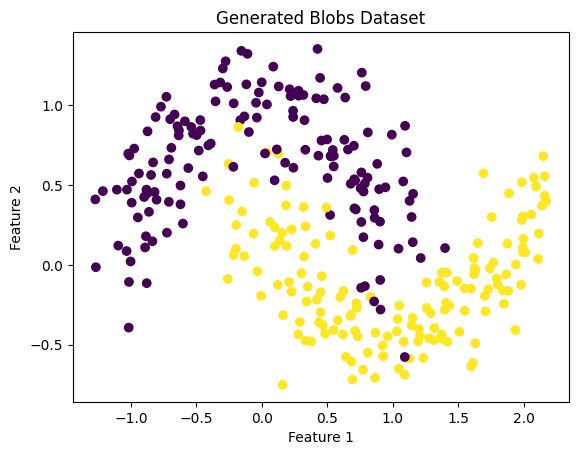

In [2]:
X, y = make_moons(n_samples=300, random_state = 3, noise = 0.18)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Blobs Dataset")
plt.show()

In [3]:
scaler = StandardScaler()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 12)

In [5]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Define the parameter grid for the MPA classifier
param_grid = {
    'learning_rate': [1.e-04, 1.e-03, 1.e-02, 1.e-01],
    'epochs': [10, 100, 150, 250, 400],
    'lambda_scaling': ['log', 'sqrt'],
    'patience': [5, 10],
    'decay_factor': [0.5, 0.75, 0.9, 1, 2],
    'min_learning_rate': [1e-6, 1e-5],
}


scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

# Create an instance of MPA
mpa = MPA(random_state=23)  # Assuming MPA has a random_state parameter

# Instantiate the GridSearchCV object:
# - 'mpa' is the estimator
# - 'param_grid' defines the parameters to try
# - 'cv=5' means 5-fold cross-validation
# - 'scoring='accuracy'' uses accuracy to compare model performance
# - 'n_jobs=-1' uses all processors for computation
grid_search = GridSearchCV(estimator=mpa, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=3)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train_minmax, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_minmax, y_test)
print("Test set score with best model: {:.2f}".format(test_score))

In [ ]:
model_fig = best_model.plot_convergence()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, best_model.predict(X_test_minmax)))
cr = classification_report(y_test, best_model.predict(X_test_minmax))

In [ ]:
xx, yy = np.meshgrid(np.linspace(X_train_minmax[:,0].min()-0.5, X_train_minmax[:,0].max()+0.5, 100),
                     np.linspace(X_train_minmax[:,1].min()-0.5, X_train_minmax[:,1].max()+0.5, 100))
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_minmax[:,0], X_train_minmax[:,1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()

In [6]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['linear']  # Explicitly set to 'linear'
}

# Create an instance of SVM
svm = SVC(random_state=42)

# Instantiate the GridSearchCV object:
# - 'svm' is the estimator
# - 'param_grid' defines the parameters to try
# - 'cv=5' means 5-fold cross-validation
# - 'scoring='accuracy'' uses accuracy to compare model performance
# - 'n_jobs=-1' uses all processors for computation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

# Evaluate the best model on the test set
best_model_new = grid_search.best_estimator_
test_score = best_model_new.score(X_test, y_test)
print("Test set score with best model: {:.2f}".format(test_score))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.83
Test set score with best model: 0.92


In [7]:
print("\nClassification Report:")
print(classification_report(y_test, best_model_new.predict(X_test)))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91        28
           1       0.89      0.97      0.93        32

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.92        60
weighted avg       0.92      0.92      0.92        60



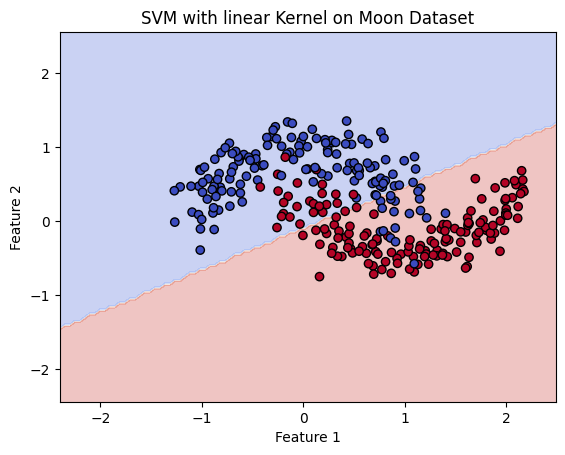

In [8]:
xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 100),
                     np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with linear Kernel on Moon Dataset")
plt.show()

In [9]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf']  # Explicitly set to 'rbf'
}

# Create an instance of SVM
svm = SVC(random_state=42)

# Instantiate the GridSearchCV object:
# - 'svm' is the estimator
# - 'param_grid' defines the parameters to try
# - 'cv=5' means 5-fold cross-validation
# - 'scoring='accuracy'' uses accuracy to compare model performance
# - 'n_jobs=-1' uses all processors for computation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

# Evaluate the best model on the test set
best_model_new = grid_search.best_estimator_
test_score = best_model_new.score(X_test, y_test)
print("Test set score with best model: {:.2f}".format(test_score))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.94
Test set score with best model: 0.98


In [10]:
print("\nClassification Report:")
print(classification_report(y_test, best_model_new.predict(X_test)))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.97      0.98        32

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



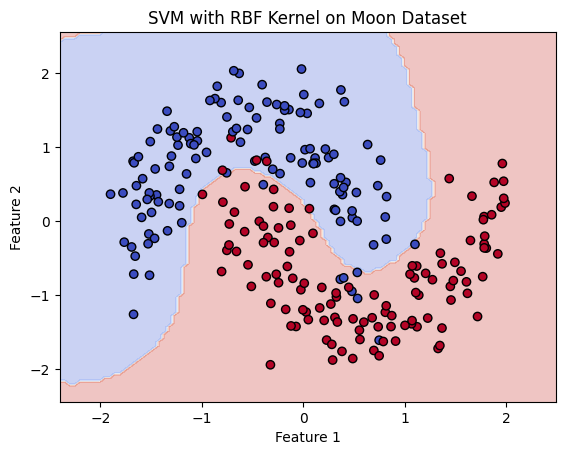

In [11]:
xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 100),
                     np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()

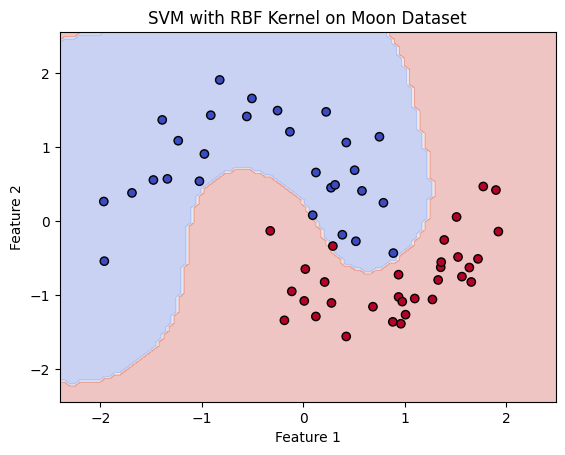

In [12]:
xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 100),
                     np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()